# Training a fraud detection model using an Autoencoder network

# What is an Autoencoder network?

An autoencoder network is an artificial neural network used for unsupervised learning.  The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction.

Architecturally, the simplest form of an autoencoder is a feedforward, non-recurrent neural network very similar to the multilayer perceptron (MLP) – having an input layer, an output layer and one or more hidden layers connecting them –, but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs (instead of predicting the target value Y given inputs X. Therefore, autoencoders are unsupervised learning models.

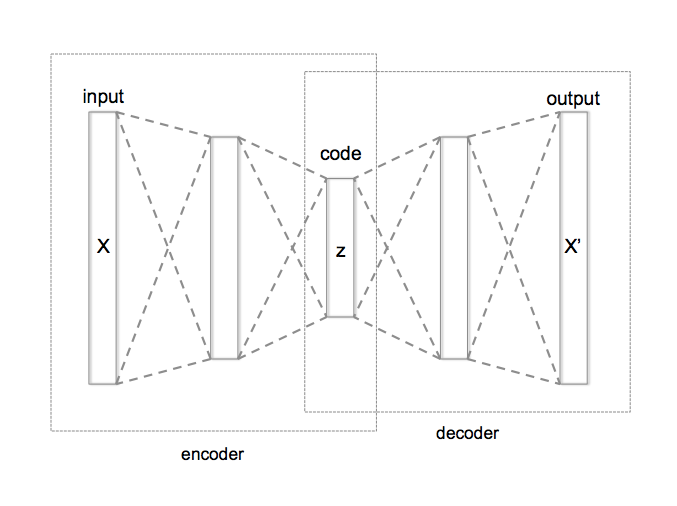


# Problem

Credit card fraud is a wide-ranging term for theft and fraud committed using or involving a payment card, such as a credit card or debit card, as a fraudulent source of funds in a transaction. As the number of fraudulent transactions is extremely small compared to the total number of transactions, the training data is highly unbalanced, and therefore the supervised classification approach usually does not perform well.

In this lab, we will explore an unsupervised learning approach to solve this problem. Specifically, we will train an Autoencoded model in Tensorflow to reconstruct normal transactions from the input data. The goal here is to minimize the reconstruction error for normal transactions.  As fraudulent transactions are not used in training, the reconstruction error rates are expected to be higher when the fraudulent dataset is run through the model.



# Overview of dataset

The dataset contains over 284,000 credit card transactions each marked as either normal or fraud.  There are 31 features, and most of the features have been transformed from their original format with the exception of the following features:
- Time
- Amount - Transaction amount
- Class - This is the class label. 0 indicates normal transaction, 1 indicates fraudulent transaction

# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as auc 
from datetime import datetime 

%matplotlib inline

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading data

In [2]:
df = pd.read_csv("data/creditcard.csv")

# Taking a look at the shape of the sample data
print ('Data shape: \t', df.shape)

Data shape: 	 (284807, 31)


# Display some sample data 

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Display the data distribution

The data will be very un-balanced as fraud cases are normally very small percentage of the total dataset

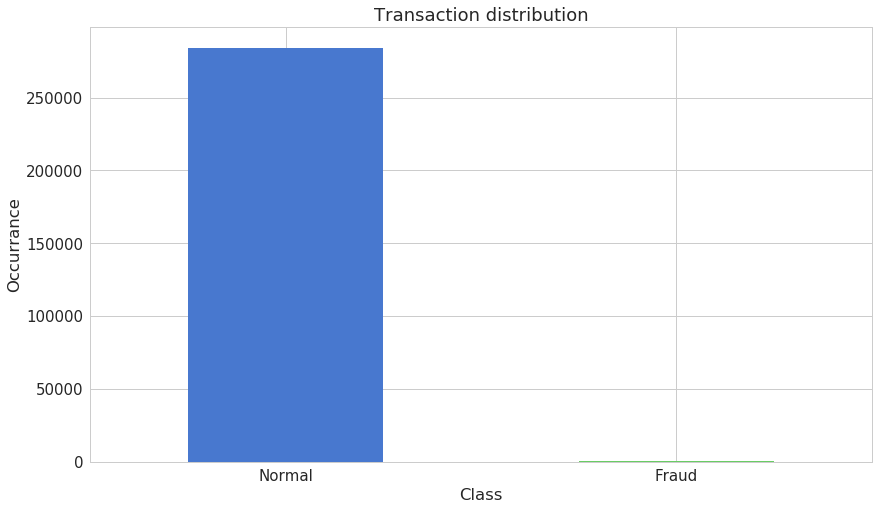

number of fraud transactions: 	 492
number of normal tranasctions: 	 284315


In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Occurrance")

plt.show()

# Display the size of the normal d
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print ('number of fraud transactions: \t', frauds.shape[0])
print ('number of normal tranasctions: \t', normal.shape[0])


In [5]:
from sklearn.preprocessing import StandardScaler
data = df

#Drop the time column as it is not needed
data = df.drop(['Time'], axis=1)  

#Normalize the amounts to be between -1 and 1.  
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# Split the data into training and testing sets

We split the data into 80% training and 20% validation. We only want to train the network using portion of the dataset that represent normal transactions.  

In [6]:
# percentage of data for validation
test_size = 0.2

X_train, X_test = train_test_split(data, test_size=test_size, random_state=RANDOM_SEED)

#For the auto encoder training, we want to learn the reconstruction error for normal transacitons only. So keeping 
#only rows where the class is 0
X_train = X_train[X_train.Class == 0]
Y_train = X_train['Class']

#Get the training features only
X_train = X_train.drop(['Class'], axis=1)


#build the labels array corresponding to the features for the testing set only
y_test = X_test['Class']
# Removing class column from the testing features
X_test = X_test.drop(['Class'], axis=1)


X_train = X_train.values
Y_train = Y_train.values
X_test = X_test.values

print ('training data shape: \t', X_train.shape)
print ('validation data shape: \t', X_test.shape)

training data shape: 	 (227451, 29)
validation data shape: 	 (56962, 29)


# Create the Autoencoder Network

In [7]:

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features
num_hidden_3 = 2  # bottleneck layer num features
num_input = X_train.shape[1] # Size of the features

inputdata = tf.placeholder("float", [None, num_input])

# Define the weights and biases for network
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_3, num_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([num_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([num_input])),
}


# Encoder layers
encoder_layer1 = tf.nn.sigmoid(tf.add(tf.matmul(inputdata, weights['encoder_h1']),
                                   biases['encoder_b1']))
encoder_layer2 = tf.nn.sigmoid(tf.add(tf.matmul(encoder_layer1, weights['encoder_h2']),
                                   biases['encoder_b2']))
encoder_layer3 = tf.nn.sigmoid(tf.add(tf.matmul(encoder_layer2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    
# Decoder layers
decoder_layer1 = tf.nn.sigmoid(tf.add(tf.matmul(encoder_layer3, weights['decoder_h1']),
                                   biases['decoder_b1']))
decoder_layer2 = tf.nn.sigmoid(tf.add(tf.matmul(decoder_layer1, weights['decoder_h2']),
                                   biases['decoder_b2']))
decoder_layer3 = tf.nn.sigmoid(tf.add(tf.matmul(decoder_layer2, weights['decoder_h3']),
                                   biases['decoder_b3']))


# Prediction
y_pred = decoder_layer3
# Targets (Labels) are the input data.
y_true = inputdata

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

learning_rate = 0.01

optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)


# Train the model


In [8]:
# Parameters
training_epochs = 10
batch_size = 256
display_step = 1


# Initializing the variables
init = tf.global_variables_initializer()

now = datetime.now()

with tf.Session() as sess:
    sess.run(init)
    total_batch = int(X_train.shape[0]/batch_size)
    for epoch in range(training_epochs):
        for batch_id in range(total_batch):
            batch_idx = np.random.choice(X_train.shape[0], batch_size)
            batch_xs = X_train[batch_idx]
            feed_dict = {inputdata: batch_xs}
            _, cost = sess.run([optimizer, loss], feed_dict=feed_dict)
            
        # Display stats 
        if epoch % display_step == 0:
            feed_dict1 = {inputdata: X_train}
            train_batch_mse = sess.run(batch_mse, feed_dict=feed_dict1)
            print("Epoch:", '%04d' % (epoch+1),
                  "Cost=", "{:.9f}".format(cost), 
                  "Time elapsed=", "{}".format(datetime.now() - now))
        
    # Save the model
    save_model = 'model/model.ckpt'
    saver = tf.train.Saver()    
    save_path = saver.save(sess, save_model)
    
    feed_dict2 = {inputdata: X_test}
    test_batch_mse = sess.run(batch_mse, feed_dict=feed_dict2)
    
    print("Test auc score: {:.6f}".format(auc(y_test, test_batch_mse)))
    


Epoch: 0001 Cost= 0.878784299 Time elapsed= 0:00:47.694911
Epoch: 0002 Cost= 1.015632868 Time elapsed= 0:00:50.236296
Epoch: 0003 Cost= 1.064621925 Time elapsed= 0:00:52.777332
Epoch: 0004 Cost= 0.856152117 Time elapsed= 0:00:55.317695
Epoch: 0005 Cost= 1.139200091 Time elapsed= 0:00:57.796026
Epoch: 0006 Cost= 0.890392363 Time elapsed= 0:01:00.265535
Epoch: 0007 Cost= 0.886256278 Time elapsed= 0:01:02.737876
Epoch: 0008 Cost= 0.800069928 Time elapsed= 0:01:05.213839
Epoch: 0009 Cost= 1.003592253 Time elapsed= 0:01:07.559382
Epoch: 0010 Cost= 0.750410557 Time elapsed= 0:01:09.820708
Test auc score: 0.953504


# Test the performance of the model with test data

In [9]:
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    feed_dict3 = {inputdata: X_test}
    test_batch_mse = sess.run(batch_mse, feed_dict=feed_dict3)
    
    print("Test auc score: {:.6f}".format(auc(y_test, test_batch_mse)))
    
    print ('test mse mean: \t', test_batch_mse.mean())
    print ('test mse std: \t', test_batch_mse.std())

INFO:tensorflow:Restoring parameters from model/model.ckpt
Test auc score: 0.953504
test mse mean: 	 0.98030674
test mse std: 	 3.739623


# Plot the ROC Curve

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.  The Area Under Curve (AUC) is a measure of the model performance.  High AUC value indicates high predictive performance.

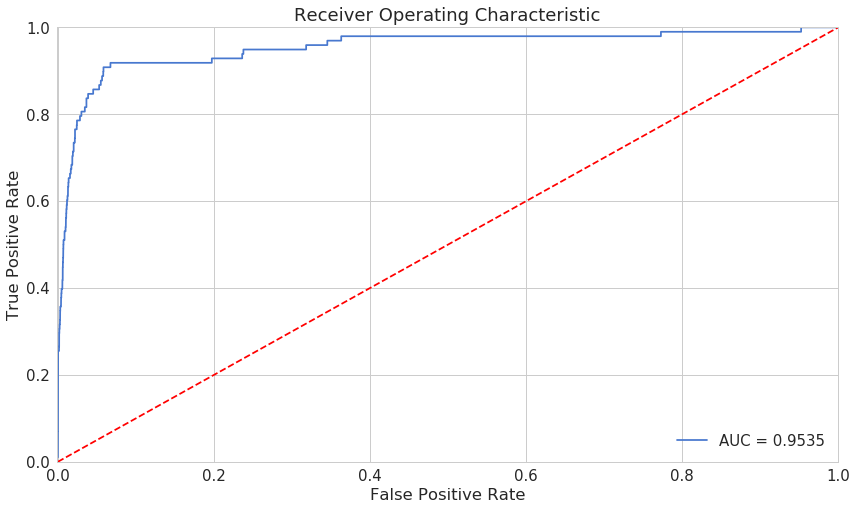

In [10]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y_test, test_batch_mse)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# Plot the reconstruction errors

In [11]:
error_df = pd.DataFrame({'reconstruction_error': test_batch_mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.980309,0.001720
std,3.739595,0.041443
min,0.105712,0.000000
25%,0.383653,0.000000
50%,0.566357,0.000000
75%,0.831926,0.000000
max,260.319427,1.000000


# Plot the reconstruction error distributions for normal and fraudulent transactions.


Text(0.5,0,'Error Rates')

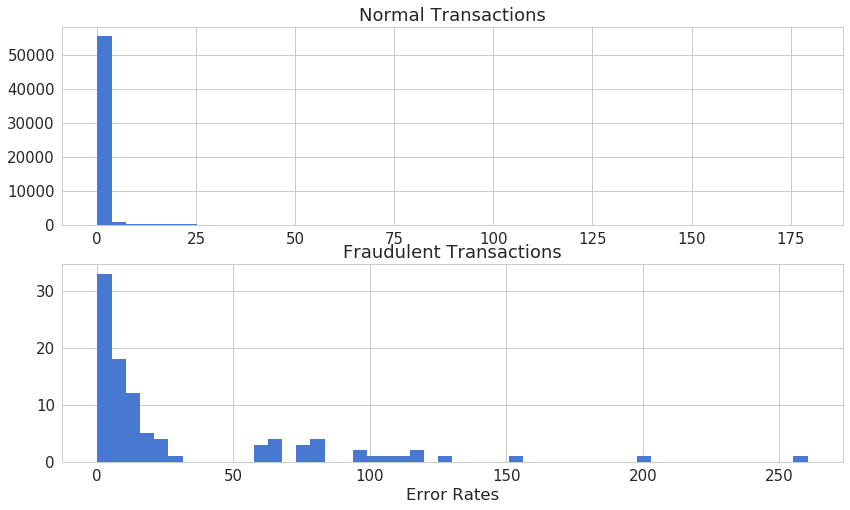

In [12]:
fig = plt.figure()


ax = fig.add_subplot(211)
normal_error_df = error_df[error_df['true_class']== 0]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=50)
ax.set_title("Normal Transactions")

ax1 = fig.add_subplot(212)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax1.hist(fraud_error_df.reconstruction_error.values, bins=50)
ax1.set_title("Fraudulent Transactions")
ax1.set_xlabel('Error Rates')


# Plot the error rates for both normal and fraudulent transaction

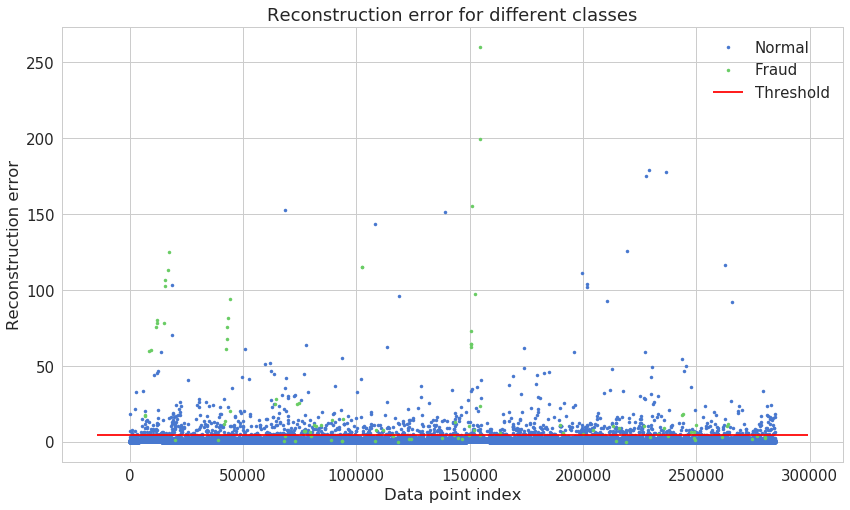

In [13]:
threshold = 4.5

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Display a confusion matrix for the outputs

Anything above the thresh is considered a fraudulent transaction.

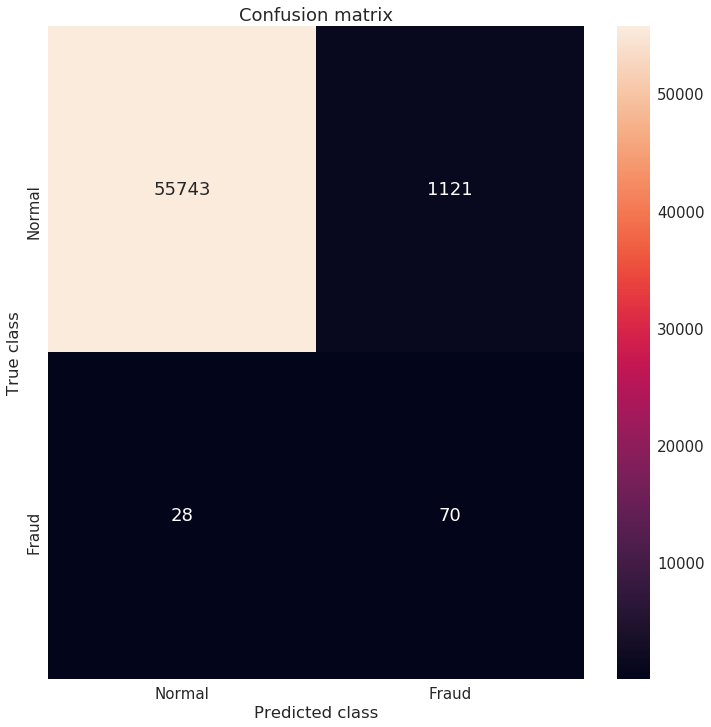

In [14]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Conclusion

In the lab, we created an autoencoder network that can detect frauds from credit card transactions. While there are some incorrect predictions, the model is able to correctly detect the majority of the fraudulent transactions.